In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import matplotlib
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd
import datetime
import pandas as pd
import numpy as np

def RestartVariables():
    global simworldname
    global groundtruth
    global motion_readings
    global my_map
    global grid_map
    global distances
    global oracle
    global analyzer
    global dataset_times
    global dataset_readings
    global dataset
    global motions_order
    global motion_sensors
    global motions_sensor_data
    global simulated_sensor_readings
    global sensors_list
    global sr_matrix
    global indices_to_keep
    global gtx
    global gty
    global rsr
    global df_
    global gtt
    global human_readable_sensor_array
    
    human_readable_sensor_array = []
    gtt = []
    gtx = []
    gty = []
    rsr = []
    indices_to_keep = [0, 1, 2, 3, 4, 5, 11, 15, 16, 17, 18, 19, 20, 21]
    simworldname = 'simulationWorld2.xml' #ENVIROMENT
    groundtruth = '28jun2.csv' #AGENT'S MOVEMENTS
    motion_readings = '28Jun2_motion_events.txt'
    # groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

    my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
    grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
    distances = []

    oracle = {}
    oracle['time'] = []
    oracle['location'] = []

    analyzer = {}
    analyzer['time'] = []
    analyzer['gridmap'] = []
    dataset_times = []
    dataset_readings = []
    dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']
    
    motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
    motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
    motions_sensor_data = {}
    simulated_sensor_readings = []
    sensors_list = []
    sr_matrix = np.zeros([1, 14])
    
    # sensor_readings = open(motion_readings, "r")
    sensor_readings = open(motion_readings, "r").readlines()

#----- Extracting sensors reading from the groundtruth dataset    
    for i in range(0,len(sensor_readings)):
        time = sensor_readings[i].split(';')[0]
        sensor_array = sensor_readings[i].split(';')[1]
        dataset_times.append(int(time))
        dataset_readings.append(sensor_array)
        
#----- Convert sensor readings to human readable format
    human_readable_sensor_array = SensorReadingInterpretation(dataset_readings)

#----- Aligning sensor readings with agent's trace
    temp_gtx = []
    temp_gty = []
    temp_gtt = []
    counter = 0
    with open(groundtruth, 'r') as user_data:
        reader = csv.reader(user_data, delimiter=',', quotechar=',')
        line = 0
        for row in reader:
            new_row = []
            if (reader.line_num != 1):
                
                if (float(row[4]) > 6.6):
                    temp_gtx.append(0.1)
                else:
                    temp_gtx.append(6.6 - float(row[4]))
                   
                temp_gty.append(float(row[5]))
                temp_gtt.append(int(row[0]))
                
            counter += 1

    gtt.append(temp_gtt[0])
    gtx.append(temp_gtx[0])
    gty.append(temp_gty[0])

    for i in range(1, len(temp_gtt)):
        if (temp_gtt[i] - temp_gtt[i - 1] <= 3):
            gtt.append(temp_gtt[i])
            gtx.append(temp_gtx[i])
            gty.append(temp_gty[i])
            
        else:
            intervals = int((temp_gtt[i] - temp_gtt[i - 1])/2)

            ts = np.linspace(temp_gtt[i - 1], temp_gtt[i], num=intervals, endpoint=True)
            xs = np.linspace(temp_gtx[i - 1], temp_gtx[i], num=intervals, endpoint=True)
            ys = np.linspace(temp_gty[i - 1], temp_gty[i], num=intervals, endpoint=True)

            for intdata in range(0, len(ts)):
                gtx.append(xs[intdata])
                gty.append(ys[intdata])
                gtt.append(ts[intdata])

    for i in range(0, len(gtt)):
        ind = find_nearest(dataset_times[1:], int(gtt[i]))
        rsr.append(human_readable_sensor_array[ind])            
    
    columns = ['time', 'gtx', 'gty', 'gt_motion_readings', 'synthetic_motion_readings']
    index = range(0, len(gtx))

    df_ = pd.DataFrame(index=index, columns=columns)

    df_.time = gtt[0: len(gtx)]
    df_.gtx = gtx[: len(gtx)]
    df_.gty = gty[: len(gtx)]
    df_.gt_motion_readings = rsr[: len(rsr)]
                
def SensorReadingInterpretation(dataset_readings):
    templist = [[0] * 14]
    for i in range(0, len(dataset_readings)):
        numlist = [int(s) for s in dataset_readings[i] if s.isdigit()]
        numlist = [numlist[j] for j in range(0, len(numlist)) if j in indices_to_keep]
        templist.append(numlist)
        
    templist_modified = [[0] * 14]
    for row in range(1, len(templist)):
        history = templist_modified[row - 1]
        row_modified = [0] * 14
        for i in range(len(history)):    
            if (templist[row][i] == 0 and history[i] == 1):
                row_modified[i] = 1
   
            elif (templist[row][i] == 0 and history[i] == 0):
                row_modified[i] = 0

            elif (templist[row][i] == 1 and history[i] == 1):
                row_modified[i] = 0

            elif (templist[row][i] == 1 and history[i] == 0):
                row_modified[i] = 1

        templist_modified.append(row_modified)

    del templist_modified[0]
    return templist
    
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    # print(value - array[idx])
    return idx

RestartVariables()

In [3]:
df_

,time,gtx,gty,gt_motion_readings,synthetic_motion_readings
0,1.498671e+09,5.402258,5.402001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
1,1.498671e+09,5.401935,5.401716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
2,1.498671e+09,5.401613,5.401430,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
3,1.498671e+09,5.401290,5.401144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
4,1.498671e+09,5.400968,5.400858,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
5,1.498671e+09,5.400645,5.400572,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
6,1.498671e+09,5.400645,5.400572,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
7,1.498671e+09,5.400613,5.400543,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
8,1.498671e+09,5.400581,5.400515,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
9,1.498671e+09,5.400548,5.400486,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN


In [4]:
for i in range(1, len(df_)):
    print(df_.time[i] - df_.time[i - 1])

1.0
1.0
1.0
1.0
1.0
0.0
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.0999999046325684
2.1000001430511475
2.0999999046325684
2.1000001430511475
2.0999999046325684
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
0.0
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
2.1176469326019287
2.117647171020508
3.0
0.0
3.0
3.0
3.0
3.0
3.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
3.0
2.0
1.0
1.0
0.0
2.4285714626312256
2.4285714626312256
2.4285714626312256
2.4285712242126465
2.428571462631

3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


In [5]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()
    r = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = str(660 - int(str(element.find('point').find('xcoord').text)))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        # print("real: ", real_localization)
        # print("simu: ", simulated_localization)
              
        return probCdf
    
class MotionSensorBinary(Sensor):
    def __init__(self, element, radius):
        Sensor.Initialize(self, element)
        # self.sensing_area = (str(element.find('radius').text))
        self.sensing_area = (str(radius))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist    

In [6]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [7]:
class GridMap:
    map = ""

In [8]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [9]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

def ParseSimulationWorld(radius):
    root = xml.etree.ElementTree.parse(simworldname).getroot()

    grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
    grid2 = np.copy(grid_map)

    for element in root:
        if(element.tag == 'sensors'):
            for sensor in element:
                #Choose the kind of sensor we have
                if(str(sensor.find('type').text) == 'RFID_Reader'):
                    this_sensor = RFID_Reader(sensor)

                if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                    this_sensor = MotionSensorBinary(sensor, radius)

                if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                    this_sensor = MotionSensorAnalog(sensor)

                if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                    this_sensor = PressureSensorAnalog(sensor)

                if(str(sensor.find('type').text) == 'BeaconSensor'):
                    this_sensor = BeaconSensor(sensor)

                sensors_list.append(this_sensor)
                print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y + " " + this_sensor.sensor_id)

In [10]:
############################################
####         LOCALIZATION CLASS         ####
############################################
class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                                 
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):   
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

        except:
            print("start!")
                
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    circ = Circle((int(float(sensor.x)/10), int(float(sensor.y)/10)), int(float(sensor.sensing_area)/10))
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
            
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        # print("infered loc:")
        # print(inferred_location)
        # print("real loc:")
        # print(type(real_location[0]))
        

        
        return np.linalg.norm(inferred_location - real_location)
            
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == time)], axis = 0)
        # print("ponto: ", point, "time: ", time)
        return point
    
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [17]:
def SimulateSensorReading(fs):
    sensor_bins = [0] * 14
    if len(fs) == 0:
        simulated_sensor_readings.append(sensor_bins)
    
    else:
        for sensor in fs:
            if (sensor.sensor_type == 'MotionSensorBinary'):
                snum = int(sensor.sensor_id.replace('sensor',''))
                sensor_bins[motion_sensors.index(snum)] = 1

        simulated_sensor_readings.append(sensor_bins)
        
        if (len(simulated_sensor_readings) % 100 == 0):
            print(len(simulated_sensor_readings))


def readFileCSV():             
    for i in range(1, len(df_)):     
        myfs = []
        no_event_flag = 1
        xtrace = df_.gtx[i]
        ytrace = df_.gty[i]
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        # print(loc)
        timetoadd = df_.time[i]
        
        # if loc not in oracle['location'] and timetoadd not in oracle['time']:
        oracle['location'].append(loc)
        oracle['time'].append(timetoadd) 
            # print(oracle)
        
        for sensor in sensors_list:
            # pp = ax.plot(int(sensor.x) / 100, int(sensor.y) / 100 , marker='.', color='k', lw=5)
            if (sensor.sensor_type == "MotionSensorBinary"):    
                circ = Circle((float(int(sensor.x) / 10), float(int(sensor.y) / 10)), float(int(sensor.sensing_area) / 10))
                if (circ.contains_point([x, y])):
                    no_event_flag = 0
                    event = Event()
                    event.sensor = sensor.sensor_id #SensorId that created the event
                    event.data = "TRUE"  #data
                    event.hash = "|hash|" #hash
                    event.source = "xmlFile" #where is coming from
                    event.timestamp = timetoadd
                    event.sensorType = sensor.sensor_type #type of sensor
                    
                    
                    # print("synthetic sensor:", int(sensor.x) / 10, int(sensor.y) / 10)
                    
                    # p3 = ax.plot(float(int(sensor.x) / 100), float(int(sensor.y) / 100) , marker='D', color='r', lw=10)
                    
                    run_localization(event)
                    myfs.append(sensor)
                
                
        # real_fired = [i for i, e in enumerate(df_.gt_motion_readings[i]) if e == 1]

        # for rf in real_fired:
            # sid = "sensor" + str(motions_order[rf])
            # for s in sensors_list:
                # if (s.sensor_id == sid):
                    # p4 = ax.plot(float(int(s.x) / 100), float(int(s.y) / 100) , marker='o', color='b', lw=5)
        
        no_event_flag = 0
        
        SimulateSensorReading(myfs) 
        
        # xlim=(0, 6)
        # ylim=(0, 10)
        # p1 = ax.plot(df_.gtx[i], df_.gty[i], marker='+', color='k', lw=10)
        # plt.xlim(*xlim)
        # plt.ylim(*ylim)
        # plt.gca().invert_yaxis()
        # plt.show()
        
        
        
        
        # fig.canvas.draw()
        # ax.cla()
        # ax.imshow(img, extent=[0, 6, 0, 10])
        

In [18]:
len(simulated_sensor_readings)

0

In [19]:
len(df_)

2766

In [24]:
def CreateUltilmateDataset():
    simulated_sensor_readings.append([0]*14)
    df_.synthetic_motion_readings = simulated_sensor_readings[0: len(gtx)]
    
def PrintingData(df):
    %matplotlib inline
    gt_readings = {}

    for sensor in range(0, 14):
        gt_readings[sensor] = []
        for i in range(0, len(df['gt_motion_readings'])):
            gt_readings[sensor].append(df['gt_motion_readings'][i][sensor])


    sim_readings = {}

    for sensor in range(0, 14):
        sim_readings[sensor] = []
        for i in range(0, len(df_['synthetic_motion_readings'])):
            sim_readings[sensor].append(df['synthetic_motion_readings'][i][sensor])
            
    import matplotlib.pyplot as plt

    for i in range(len(gt_readings)):
        # xticks(np.arange(12), df_.times, rotation=90)
        plt.figure(figsize=(10,6))
        plt.plot(list(range(0,len(gt_readings[i]))), gt_readings[i], label='Real Sensor Readings')
        plt.plot(list(range(0,len(sim_readings[i]))), sim_readings[i], label='Synthetic Sensor Readings')
        plt.legend()
        plt.show()

    plt.tight_layout()

BeaconSensor 181 405 sensorBC1
PressureSensorAnalog 181 405 sensorPS1
MotionSensorBinary 205 405 sensor1
MotionSensorBinary 181 284 sensor2
MotionSensorBinary 151 101 sensor3
MotionSensorBinary 477 389 sensor4
MotionSensorBinary 389 225 sensor5
MotionSensorBinary 569 225 sensor6
MotionSensorBinary 194 894 sensor7
MotionSensorBinary 234 626 sensor8
MotionSensorBinary 538 861 sensor9
MotionSensorBinary 416 1003 sensor10
MotionSensorBinary 445 711 sensor11
MotionSensorBinary 477 577 sensor12
MotionSensorBinary 86 527 sensor13
MotionSensorBinary 86 688 sensor14
start!
700
800
900
1000
1100
1200
1300
1700
1800
2000
2100
2200
2300
2400
2500
2600
2700
------------radius change
100


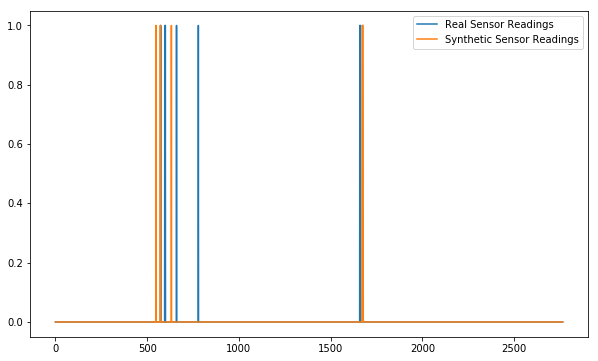

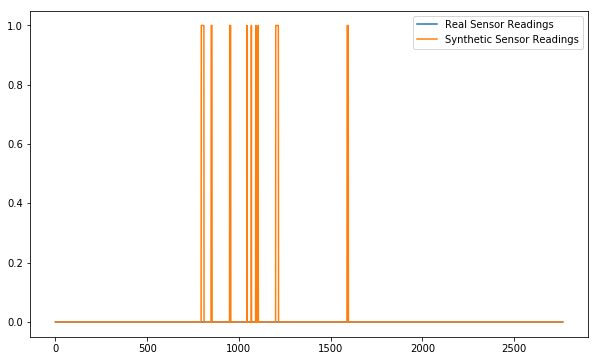

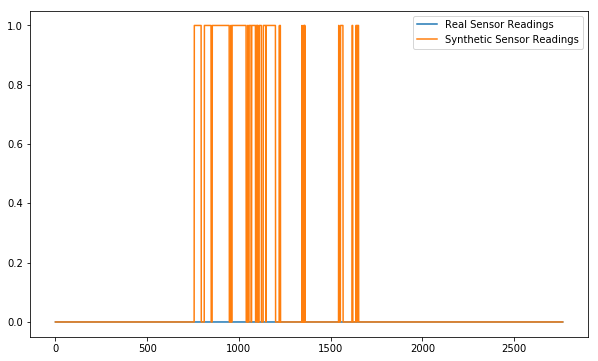

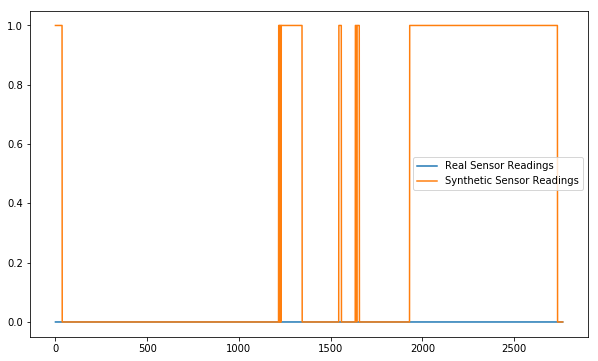

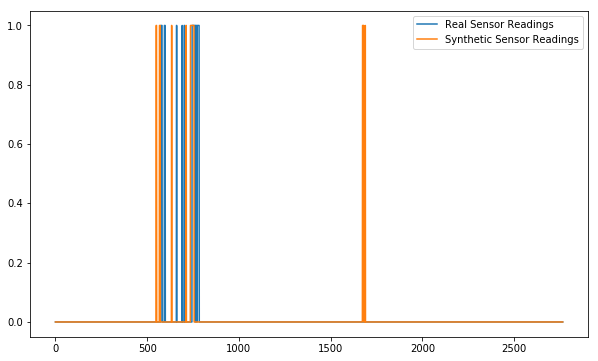

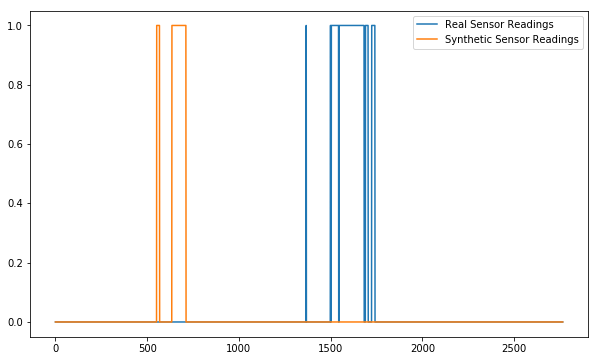

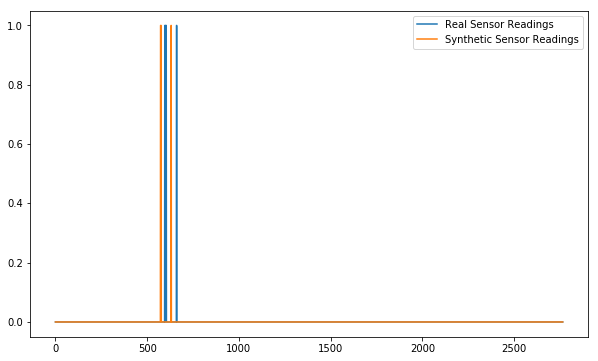

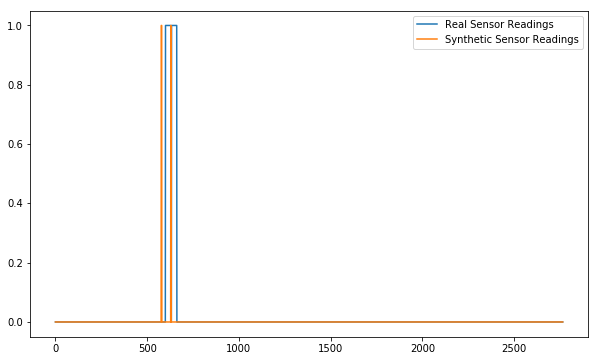

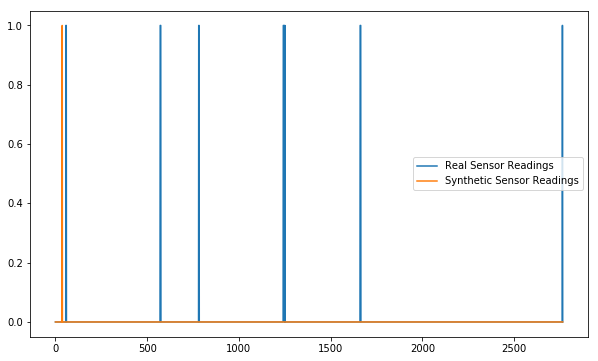

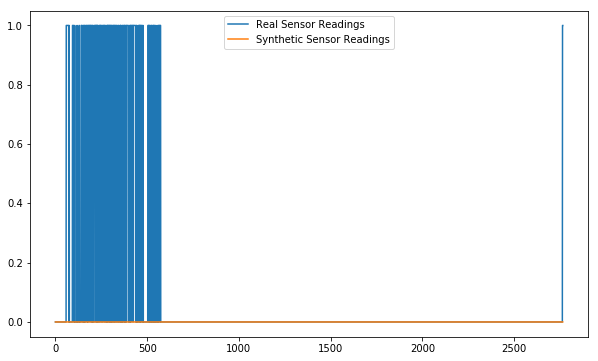

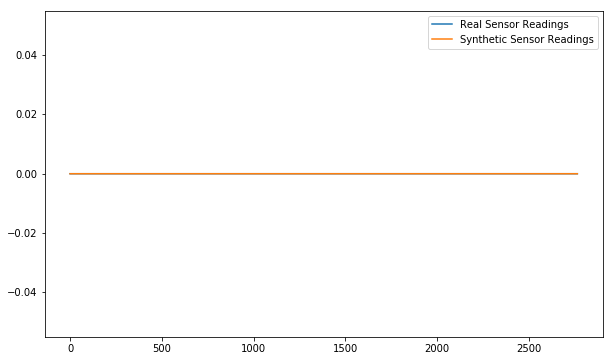

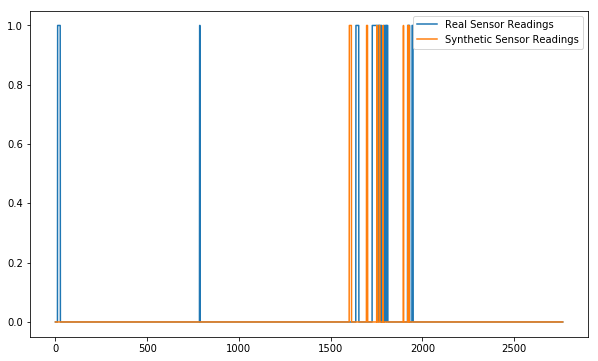

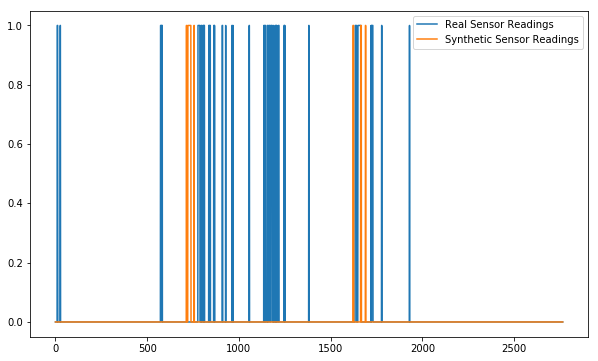

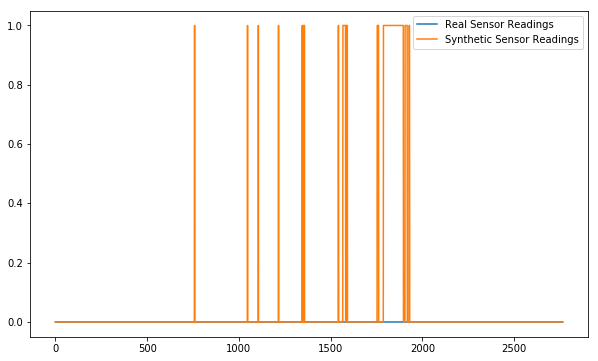

<Figure size 432x288 with 0 Axes>

In [27]:
radius_array = [100]

global fig
global ax

# %matplotlib notebook

# fig, ax = plt.subplots(figsize = (6, 10))

# plt.ion()
# fig = plt.figure()

# plt.figure()
# img = plt.imread("sc.png")
# fig, ax = plt.subplots(figsize=(5, 10))
# ax.imshow(img, extent=[0, 7, 0, 11])



for r in radius_array:
    RestartVariables()
    ParseSimulationWorld(r)

    readFileCSV()
    
    print("------------radius change")
    print(r)
    
    
    CreateUltilmateDataset()
    PrintingData(df_)

In [ ]:
%matplotlib inline

CreateUltilmateDataset()
PrintingData(df_)

In [ ]:
len(df_)

In [ ]:
len(simulated_sensor_readings)

In [ ]:
for i in range(1, len(df_)):
    # print(df_.time[i] - df_.time[i - 1])
    print(df_.time[i - 1])

In [ ]:
df_.gt_motion_readings.head()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)

In [ ]:
from random import shuffle
x = [i for i in range(8)]
shuffle(x)
print(x)

In [ ]:
x